# Data Mart configuration and usage with `ibm-ai-openscale` python package

<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/image.png" align="left" alt="banner" width="100">

This notebook shows hot to create a data mart for Watson Machine Learning deployments. It includes steps for performance, bias and quality monitor configurations.

Contents
- [1. Setup](#setup)
- [2. Binding machine learning engine](#binding)
- [3. Subscriptions](#subscription)
- [4. Score models](#scoring)
- [5. Data Mart](#datamart)
- [6. Visualization](#visualization)

<a id="setup"></a>
## 1. Setup

### 1.1 Installation and authentication

In [25]:
!pip install --upgrade ibm-ai-openscale

Requirement already up-to-date: ibm-ai-openscale in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-ai-openscale)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-ai-openscale)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-ai-openscale)
Requirement not upgraded as not directly required: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-ai-openscale)
Requirement not upgraded as not directly required: psycopg2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-ai-openscale)
Requirement not upgraded as not directly required: python-dateutil>=2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pandas->ibm-ai-

In [26]:
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/

### ACTION: Restart kernel to make sure installed versions are used.

Import and initiate.

In [27]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *

### ACTION: Get `data_mart_id` (GUID) and `apikey`

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get DATA_MART_ID (this is AI OpenScale instance GUID)
```
bx resource service-instance ‘instance_name’
```


In [28]:
aios_credentials = {
  "data_mart_id": "*****",
  "apikey": "*****", 
  "url": "https://api.aiopenscale.cloud.ibm.com"
}

In [73]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your Watson Machine Learning credentials here

In [74]:
wml_credentials =  {
  "apikey": "***",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/181ed6cc388f47bd9d862fe066f9cfce:c419e24a-c4eb-41b4-a2e1-ce4f0d298428::",
  "iam_apikey_name": "auto-generated-apikey-33f864a1-9958-4a32-b9ab-6fd962f98522",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/181ed6cc388f47bd9d862fe066f9cfce::serviceid:ServiceId-e847629a-195e-455d-a949-957263b867ab",
  "instance_id": "***",
  "password": "***",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "*****"
}

In [75]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your PostgreSQL credentials here

In [78]:
postgres_credentials = {
    "db_type": "postgresql",
    "uri": "<put correct uri here>"
}

In [79]:
# The code was removed by Watson Studio for sharing.

In [80]:
client = APIClient(aios_credentials)

In [81]:
client.version

'1.0.50'

Put your schema name here.

In [82]:
schemaName = 'data_mart'

You can use the code below to create the schema. If the schema already exists skipp this cell.

In [83]:
import psycopg2

hostname = postgres_credentials['uri'].split('@')[1].split(':')[0]
port = postgres_credentials['uri'].split('@')[1].split(':')[1].split('/')[0]
user = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[0]
password = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[1]
dbname = 'compose'

conn_string = "host=" + hostname + " port=" + port + " dbname=" + dbname + " user=" + user + " password=" + password
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()
try:
    query = "drop schema " + schemaName + " cascade"
    cursor.execute(query)
except:
    pass
finally:    
    try:
        query = "create schema " + schemaName
        cursor.execute(query)
    finally:    
        conn.close()

### 1.2 DataMart setup

In [84]:
client.data_mart.setup(postgres_credentials=postgres_credentials, schema=schemaName)

In [85]:
data_mart_details = client.data_mart.get_details()

Data Mart with instance id name has been created.

<a id="binding"></a>

## 2. Bind machine learning engines

### 2.1 Bind Watson Machine Learning 

You can bind you Watson Machine Learning instance to previously created data mart.

In [86]:
binding_uid = client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(wml_credentials))

In [87]:
bindings_details = client.data_mart.bindings.get_details()

In [88]:
client.data_mart.bindings.list()

a73bf76d-a663-448a-b771-4f651f73d54e,WML instance,watson_machine_learning,2018-11-02T13:06:30.347Z


### 2.2 Check available assets from binded services

#### List available assets

In [89]:
client.data_mart.bindings.list_assets()

8d3fdf56-57fd-4a37-b614-01caada3507f,drug-selection,2018-11-02T11:13:53.971Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,-


#### Get metadata of available assets

In [90]:
assets_details = client.data_mart.bindings.get_asset_details()

In [91]:
source_assets_uids = []

for x in client.data_mart.bindings.get_asset_details():
    source_assets_uids.append(x['source_uid'])

In [92]:
print(str(source_assets_uids))

['8d3fdf56-57fd-4a37-b614-01caada3507f']


<a id="subscriptions"></a>
## 3. Subscriptions

### 3.1 Add subscriptions

In [93]:
for uid in source_assets_uids:
    sub = client.data_mart.subscriptions.add(WatsonMachineLearningAsset(uid))
    print("Adding subscription for: " + str(uid))

Adding subscription for: 8d3fdf56-57fd-4a37-b614-01caada3507f


#### Get subscriptions list

In [94]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['8d3fdf56-57fd-4a37-b614-01caada3507f']


#### List subscriptions

In [95]:
client.data_mart.subscriptions.list()

8d3fdf56-57fd-4a37-b614-01caada3507f,drug-selection,model,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,2018-11-02T13:06:37.473Z


### 3.2 Enable payload logging and performance monitor for both subscribed assets

In [96]:
for uid in subscriptions_uids:
    subscription = client.data_mart.subscriptions.get(uid)
    subscription.payload_logging.enable()
    subscription.performance_monitoring.enable()

#### Get details of enabled payload logging

In [97]:
payload_logging_details = subscription.payload_logging.get_details()

#### Print schema of payload_logging table

In [98]:
subscription.payload_logging.print_table_schema()

scoring_id,text,-,-,-,N
scoring_timestamp,timestamp,8,-,-,N
deployment_id,text,-,-,-,N
asset_revision,text,-,-,-,N
AGE,int4,4,-,-,N
SEX,text,-,-,-,N
BP,text,-,-,-,N
CHOLESTEROL,text,-,-,-,N
NA,numeric,21,21,2,N
K,numeric,21,21,2,N
prediction,float8,8,-,-,N


### 3.3 Enable Quality (Accuracy) monitor for best heart drug asset

#### Quality monitoring

Get the subscription IDs for heart-drug and CARS4U models

In [99]:
subscriptions_details = client.data_mart.subscriptions.get_details()
heart_drug_subscription_uid = None
cars4u_subscription_uid = None

for s in subscriptions_details['subscriptions']:
    asset_name = s['entity']['asset']['name']
    if 'drug' in asset_name.lower():
        heart_drug_subscription_uid = s['metadata']['guid']
    elif 'cars4u' in asset_name.lower():
        cars4u_subscription_uid = s['metadata']['guid']

In [100]:
subscription = client.data_mart.subscriptions.get(heart_drug_subscription_uid)

#### ACTION: Put your Spark Service credentials here

In [101]:
spark_credentials = {
                  "tenant_id": "****",
                  "tenant_id_full": "915544ce-9411-437e-8ad5-a45c0b14cebb_01b7600f-62c7-4f5a-974b-9fffe65d1ab9",
                  "cluster_master_url": "https://spark.bluemix.net",
                  "tenant_secret": "***",
                  "instance_id": "****",
                  "plan": "ibm.SparkService.PayGoPersonal"
}

In [102]:
# The code was removed by Watson Studio for sharing.

#### Enable Accuracy monitor for selected subscription

In [103]:
subscription.quality_monitoring.enable(evaluation_method='multiclass', threshold=0.8, min_records=5, spark_credentials=spark_credentials)

#### Send some feedback records to feedback store. 

Feedback records are used to evaluate our model.

In [104]:
subscription.feedback_logging.store(
            [
                [20.0, 'M', 'HIGH', 'HIGH', 0.715337, 0.074773, 'drugB'],
                [38.0, 'F', 'HIGH', 'NORMAL', 0.868924, 0.061023, 'drugB'],
                [68.0, 'F', 'HIGH', 'NORMAL', 0.77541, 0.0761, 'drugB'],
                [65.0, 'M', 'HIGH', 'NORMAL', 0.635551, 0.056043, 'drugB'],
                [30.0, 'F', 'HIGH', 'HIGH', 0.800607, 0.060181, 'drugB'],
                [70.0, 'M', 'HIGH', 'HIGH', 0.658606, 0.047153, 'drugB'],
                [60.0, 'M', 'HIGH', 'HIGH', 0.805651, 0.057821, 'drugB'],
                [59.0, 'M', 'HIGH', 'HIGH', 0.816356, 0.058583, 'drugB'],
                [60.0, 'F', 'HIGH', 'HIGH', 0.800607, 0.060181, 'drugB'],
                [70.0, 'M', 'HIGH', 'HIGH', 0.658606, 0.047153, 'drugB'],
                [60.0, 'M', 'HIGH', 'HIGH', 0.805651, 0.057821, 'drugB'],
                [59.0, 'M', 'HIGH', 'HIGH', 0.816356, 0.058583, 'drugB']
            ],
            fields=['AGE', 'SEX', 'BP', 'CHOLESTEROL', 'NA', 'K', 'DRUG']
        )

**Hint:** Since Accuracy (Quality) monitor is executed every hour first result wilb be available after hour.

### 3.4 Enable Fairness monitor for best hurt drug asset

#### Configure monitor

In [105]:
from ibm_ai_openscale.supporting_classes import *

subscription.fairness_monitoring.enable(
            features=[
                Feature("AGE", majority=[[49,59],[60,75]], minority=[[0,48],[76,99]], threshold=0.8),
                Feature("SEX", majority=['M'], minority=['F'], threshold=0.8)
            ],
            prediction_column='predictedLabel',
            favourable_classes=['drugX', 'drugY'],
            unfavourable_classes=['drugA', 'drugB', 'drugC'],
            min_records=12
        )

**Hint:** Fairness monitor is executed every hour. You can also call it on demand by executing this commmand: `subscription.fairness_monitoring.run()`.

<a id="scoring"></a>
## 4. Score models
Working with `watson-machine-learning-client`.

#### Get the initialized `watson-machine-learning` client

In [106]:
wml_client = client.data_mart.bindings.get_native_engine_client(binding_uid=binding_uid)

`watson-machine-learning-client` documentation can be found [here](wml-api-pyclient.mybluemix.net).

Let's list our deployments.

In [107]:
wml_client.deployments.list()

------------------------------------  --------------------------  ------  --------------  ------------------------  ---------  -------------
GUID                                  NAME                        TYPE    STATE           CREATED                   FRAMEWORK  ARTIFACT TYPE
c6910b7e-2440-41d0-81f1-a098ec041273  best-drug model deployment  online  DEPLOY_SUCCESS  2018-11-02T13:01:57.449Z  mllib-2.1  model
------------------------------------  --------------------------  ------  --------------  ------------------------  ---------  -------------


Let's extract scoring_ednpoints for both deployments.

In [110]:
heart_scoring_endpoint = None

for deployment in wml_client.deployments.get_details()['resources']:
    if 'drug' in deployment['entity']['deployable_asset']['name'].lower():
      heart_scoring_endpoint = deployment['entity']['scoring_url']

### 4.1 Score the best-heart drug model

In [137]:
payload_scoring = {"fields": ["AGE", "SEX", "BP", "CHOLESTEROL","NA","K"], "values": [[43, "M", "HIGH", "HIGH", 0.656371, 0.046979, "drugA"], [32, "M", "HIGH", "NORMAL", 0.52975, 0.056087, "drugA"], [37, "F", "HIGH", "HIGH", 0.559171, 0.042713, "drugA"], [24, "M", "HIGH", "NORMAL", 0.613261, 0.064726, "drugA"], [29, "M", "HIGH", "HIGH", 0.625272, 0.048637, "drugA"], [36, "F", "HIGH", "HIGH", 0.734119, 0.065556, "drugA"], [19, "F", "HIGH", "HIGH", 0.516973, 0.038832, "drugA"], [38, "F", "HIGH", "NORMAL", 0.733842, 0.064793, "drugA"], [31, "M", "HIGH", "NORMAL", 0.695183, 0.058559, "drugA"], [45, "F", "HIGH", "HIGH", 0.547821, 0.042619, "drugA"], [50, "M", "HIGH", "HIGH", 0.518285, 0.069193, "drugA"], [32, "F", "HIGH", "NORMAL", 0.724375, 0.070383, "drugA"], [35, "F", "HIGH", "HIGH", 0.869854, 0.06746, "drugA"], [49, "M", "HIGH", "NORMAL", 0.500169, 0.079788, "drugA"], [39, "M", "HIGH", "HIGH", 0.731091, 0.075652, "drugA"], [26, "F", "HIGH", "NORMAL", 0.781928, 0.063535, "drugA"], [49, "M", "HIGH", "NORMAL", 0.538183, 0.061859, "drugA"], [31, "M", "HIGH", "NORMAL", 0.749717, 0.06678, "drugA"], [20, "F", "HIGH", "HIGH", 0.887426, 0.078798, "drugA"], [42, "M", "HIGH", "NORMAL", 0.85794, 0.067203, "drugA"], [48, "M", "HIGH", "NORMAL", 0.769197, 0.073633, "drugA"], [47, "M", "HIGH", "HIGH", 0.56332, 0.054152, "drugA"], [23, "M", "HIGH", "HIGH", 0.53406, 0.066666, "drugA"], [60, "M", "HIGH", "NORMAL", 0.635762, 0.073744, "drugB"], [68, "M", "HIGH", "HIGH", 0.639888, 0.058123, "drugB"], [57, "F", "HIGH", "NORMAL", 0.754166, 0.075832, "drugB"], [70, "M", "HIGH", "HIGH", 0.589493, 0.059854, "drugB"], [47, "M", "LOW", "HIGH", 0.739309, 0.056468, "drugC"], [47, "M", "LOW", "HIGH", 0.697269, 0.068944, "drugC"], [41, "M", "LOW", "HIGH", 0.766635, 0.069461, "drugC"], [47, "F", "LOW", "HIGH", 0.896056, 0.076147, "drugC"], [23, "M", "LOW", "HIGH", 0.55906, 0.076609, "drugC"], [59, "F", "LOW", "HIGH", 0.640455, 0.06132, "drugC"], [72, "M", "LOW", "HIGH", 0.50482, 0.074573, "drugC"], [56, "F", "LOW", "HIGH", 0.848774, 0.07338, "drugC"], [16, "M", "LOW", "HIGH", 0.743021, 0.061886, "drugC"], [28, "F", "NORMAL", "HIGH", 0.563682, 0.072289, "drugX"], [22, "F", "NORMAL", "HIGH", 0.676901, 0.078647, "drugX"], [50, "F", "NORMAL", "HIGH", 0.82778, 0.065166, "drugX"], [69, "M", "LOW", "NORMAL", 0.848948, 0.074111, "drugX"], [49, "F", "NORMAL", "NORMAL", 0.694689, 0.074055, "drugX"], [18, "F", "NORMAL", "NORMAL", 0.553567, 0.063265, "drugX"], [49, "M", "LOW", "NORMAL", 0.625889, 0.056828, "drugX"], [53, "M", "NORMAL", "HIGH", 0.644936, 0.045632, "drugX"], [46, "M", "NORMAL", "NORMAL", 0.526226, 0.072234, "drugX"], [39, "M", "LOW", "NORMAL", 0.604973, 0.043404, "drugX"], [39, "F", "NORMAL", "NORMAL", 0.517515, 0.053301, "drugX"], [15, "M", "NORMAL", "HIGH", 0.64236, 0.07071, "drugX"], [23, "M", "NORMAL", "HIGH", 0.593596, 0.048417, "drugX"], [50, "F", "NORMAL", "NORMAL", 0.601915, 0.048957, "drugX"], [66, "F", "NORMAL", "NORMAL", 0.611333, 0.075412, "drugX"], [67, "M", "NORMAL", "NORMAL", 0.846892, 0.077711, "drugX"], [60, "M", "NORMAL", "NORMAL", 0.645515, 0.063971, "drugX"], [45, "M", "LOW", "NORMAL", 0.532632, 0.063636, "drugX"], [17, "M", "NORMAL", "NORMAL", 0.722286, 0.06668, "drugX"], [24, "F", "NORMAL", "HIGH", 0.80554, 0.07596, "drugX"], [32, "F", "LOW", "NORMAL", 0.724422, 0.066829, "drugX"], [64, "M", "NORMAL", "HIGH", 0.5126, 0.066049, "drugX"], [51, "F", "NORMAL", "HIGH", 0.678646, 0.04991, "drugX"], [36, "M", "LOW", "NORMAL", 0.52765, 0.046188, "drugX"], [56, "M", "NORMAL", "HIGH", 0.627866, 0.070026, "drugX"], [37, "M", "LOW", "NORMAL", 0.616692, 0.068765, "drugX"], [22, "M", "NORMAL", "HIGH", 0.536324, 0.044871, "drugX"], [47, "F", "NORMAL", "NORMAL", 0.526835, 0.078828, "drugX"], [35, "M", "LOW", "NORMAL", 0.685143, 0.074717, "drugX"], [65, "F", "LOW", "NORMAL", 0.760221, 0.055214, "drugX"], [20, "F", "NORMAL", "NORMAL", 0.581591, 0.062667, "drugX"], [67, "M", "NORMAL", "NORMAL", 0.721257, 0.075808, "drugX"], [40, "F", "NORMAL", "HIGH", 0.512517, 0.05073, "drugX"], [35, "M", "NORMAL", "NORMAL", 0.523623, 0.066745, "drugX"], [32, "F", "NORMAL", "HIGH", 0.549375, 0.073474, "drugX"], [49, "M", "LOW", "NORMAL", 0.510473, 0.037539, "drugX"], [74, "M", "LOW", "NORMAL", 0.787812, 0.065984, "drugX"], [69, "F", "NORMAL", "HIGH", 0.773798, 0.076882, "drugX"], [61, "M", "NORMAL", "HIGH", 0.745123, 0.078906, "drugX"], [37, "F", "LOW", "NORMAL", 0.804155, 0.066981, "drugX"], [61, "F", "LOW", "NORMAL", 0.522891, 0.071238, "drugX"], [55, "M", "NORMAL", "NORMAL", 0.509181, 0.070126, "drugX"], [72, "F", "LOW", "NORMAL", 0.7586, 0.05181, "drugX"], [34, "F", "LOW", "NORMAL", 0.825542, 0.063881, "drugX"], [30, "F", "NORMAL", "HIGH", 0.501956, 0.048067, "drugX"], [43, "M", "NORMAL", "NORMAL", 0.538856, 0.041905, "drugX"], [57, "F", "NORMAL", "HIGH", 0.596099, 0.041931, "drugX"], [28, "F", "NORMAL", "HIGH", 0.744956, 0.057843, "drugX"], [45, "M", "LOW", "NORMAL", 0.71486, 0.071367, "drugX"], [59, "F", "NORMAL", "HIGH", 0.882486, 0.063563, "drugX"], [20, "F", "LOW", "NORMAL", 0.811023, 0.069402, "drugX"], [52, "M", "NORMAL", "HIGH", 0.549945, 0.055581, "drugX"], [23, "M", "NORMAL", "NORMAL", 0.78452, 0.055959, "drugX"], [40, "F", "LOW", "NORMAL", 0.683503, 0.060226, "drugX"], [23, "F", "HIGH", "HIGH", 0.792535, 0.031258, "drugY"], [61, "F", "LOW", "HIGH", 0.559294, 0.030998, "drugY"], [49, "F", "NORMAL", "HIGH", 0.789637, 0.048518, "drugY"], [60, "M", "NORMAL", "HIGH", 0.777205, 0.05123, "drugY"], [43, "M", "LOW", "NORMAL", 0.526102, 0.027164, "drugY"], [34, "F", "HIGH", "NORMAL", 0.667775, 0.034782, "drugY"], [43, "M", "LOW", "HIGH", 0.626527, 0.040746, "drugY"], [74, "F", "LOW", "HIGH", 0.792674, 0.037851, "drugY"], [16, "F", "HIGH", "NORMAL", 0.833837, 0.053742, "drugY"], [32, "F", "HIGH", "NORMAL", 0.643455, 0.024773, "drugY"], [57, "M", "LOW", "NORMAL", 0.536746, 0.028061, "drugY"], [63, "M", "NORMAL", "HIGH", 0.616117, 0.023773, "drugY"], [47, "M", "LOW", "NORMAL", 0.809199, 0.026472, "drugY"], [48, "F", "LOW", "HIGH", 0.87444, 0.058155, "drugY"], [33, "F", "LOW", "HIGH", 0.858387, 0.025634, "drugY"], [28, "F", "HIGH", "NORMAL", 0.556833, 0.029604, "drugY"], [31, "M", "HIGH", "HIGH", 0.740936, 0.0244, "drugY"], [39, "F", "LOW", "NORMAL", 0.649096, 0.028598, "drugY"], [45, "M", "LOW", "HIGH", 0.753504, 0.041976, "drugY"], [65, "F", "HIGH", "NORMAL", 0.828898, 0.026004, "drugY"], [73, "F", "NORMAL", "HIGH", 0.832683, 0.043321, "drugY"], [50, "M", "NORMAL", "NORMAL", 0.747815, 0.04736, "drugY"], [23, "M", "NORMAL", "HIGH", 0.888629, 0.028045, "drugY"], [28, "F", "LOW", "HIGH", 0.606933, 0.030659, "drugY"], [58, "F", "HIGH", "HIGH", 0.560854, 0.028886, "drugY"], [62, "M", "LOW", "NORMAL", 0.804173, 0.029584, "drugY"], [24, "F", "HIGH", "NORMAL", 0.648646, 0.035144, "drugY"], [40, "M", "HIGH", "HIGH", 0.557133, 0.020022, "drugY"], [34, "M", "HIGH", "HIGH", 0.888144, 0.047486, "drugY"], [38, "F", "LOW", "NORMAL", 0.598753, 0.020042, "drugY"], [67, "M", "LOW", "NORMAL", 0.820638, 0.039657, "drugY"], [68, "F", "NORMAL", "NORMAL", 0.821584, 0.030373, "drugY"], [54, "M", "NORMAL", "HIGH", 0.504995, 0.02048, "drugY"], [18, "F", "HIGH", "NORMAL", 0.564811, 0.023266, "drugY"], [28, "F", "NORMAL", "HIGH", 0.860775, 0.04375, "drugY"], [41, "F", "NORMAL", "NORMAL", 0.844196, 0.036857, "drugY"], [31, "M", "HIGH", "NORMAL", 0.88624, 0.051922, "drugY"], [26, "M", "LOW", "NORMAL", 0.790664, 0.037815, "drugY"], [26, "F", "HIGH", "NORMAL", 0.823793, 0.042994, "drugY"], [69, "M", "LOW", "HIGH", 0.854733, 0.055221, "drugY"], [37, "F", "HIGH", "NORMAL", 0.795312, 0.034443, "drugY"], [50, "F", "NORMAL", "NORMAL", 0.73961, 0.042972, "drugY"], [62, "M", "NORMAL", "HIGH", 0.755873, 0.045551, "drugY"], [41, "M", "HIGH", "NORMAL", 0.658397, 0.043442, "drugY"], [29, "F", "HIGH", "HIGH", 0.857934, 0.029132, "drugY"], [42, "F", "LOW", "NORMAL", 0.763404, 0.026081, "drugY"], [56, "M", "LOW", "HIGH", 0.812663, 0.054123, "drugY"], [58, "F", "LOW", "HIGH", 0.886865, 0.023188, "drugY"], [56, "F", "HIGH", "HIGH", 0.750962, 0.029571, "drugY"], [20, "M", "HIGH", "NORMAL", 0.764067, 0.021439, "drugY"], [15, "F", "HIGH", "NORMAL", 0.697052, 0.041677, "drugY"], [22, "M", "HIGH", "NORMAL", 0.860621, 0.030417, "drugY"], [42, "M", "LOW", "HIGH", 0.756097, 0.03778, "drugY"], [23, "M", "NORMAL", "HIGH", 0.543355, 0.032247, "drugY"], [51, "M", "HIGH", "HIGH", 0.83849, 0.045831, "drugY"], [61, "F", "HIGH", "HIGH", 0.63126, 0.02478, "drugY"], [28, "M", "NORMAL", "HIGH", 0.584179, 0.021585, "drugY"], [15, "M", "HIGH", "NORMAL", 0.58301, 0.033885, "drugY"], [34, "M", "NORMAL", "HIGH", 0.602557, 0.026833, "drugY"], [36, "F", "NORMAL", "HIGH", 0.563217, 0.033618, "drugY"], [19, "F", "HIGH", "NORMAL", 0.742092, 0.028576, "drugY"], [66, "M", "HIGH", "HIGH", 0.84985, 0.051988, "drugY"], [47, "M", "LOW", "NORMAL", 0.84773, 0.025274, "drugY"], [70, "F", "NORMAL", "HIGH", 0.725424, 0.035406, "drugY"], [52, "M", "LOW", "NORMAL", 0.663146, 0.020143, "drugY"], [24, "M", "NORMAL", "HIGH", 0.854591, 0.033142, "drugY"], [42, "F", "HIGH", "HIGH", 0.533228, 0.025348, "drugY"], [64, "F", "LOW", "NORMAL", 0.554182, 0.021529, "drugY"], [74, "M", "HIGH", "NORMAL", 0.818999, 0.053057, "drugY"], [37, "M", "LOW", "NORMAL", 0.73154, 0.043743, "drugY"], [53, "M", "LOW", "HIGH", 0.618603, 0.026939, "drugY"], [21, "F", "HIGH", "NORMAL", 0.745098, 0.026023, "drugY"], [16, "M", "HIGH", "NORMAL", 0.561019, 0.029516, "drugY"], [38, "M", "LOW", "HIGH", 0.851019, 0.046516, "drugY"], [58, "F", "LOW", "HIGH", 0.887928, 0.033324, "drugY"], [51, "F", "LOW", "NORMAL", 0.876828, 0.038118, "drugY"], [39, "F", "NORMAL", "NORMAL", 0.809196, 0.046978, "drugY"], [41, "F", "LOW", "NORMAL", 0.749905, 0.040018, "drugY"], [73, "F", "HIGH", "HIGH", 0.808019, 0.044038, "drugY"], [25, "M", "NORMAL", "HIGH", 0.775702, 0.040803, "drugY"], [39, "M", "NORMAL", "HIGH", 0.609566, 0.038171, "drugY"], [67, "F", "NORMAL", "HIGH", 0.785251, 0.049416, "drugY"], [22, "F", "HIGH", "NORMAL", 0.817625, 0.035832, "drugY"], [36, "F", "HIGH", "NORMAL", 0.575058, 0.037124, "drugY"], [18, "F", "HIGH", "HIGH", 0.88515, 0.023802, "drugY"], [57, "F", "NORMAL", "NORMAL", 0.551967, 0.021317, "drugY"], [65, "M", "HIGH", "NORMAL", 0.8645, 0.024702, "drugY"], [64, "M", "HIGH", "NORMAL", 0.739914, 0.035349, "drugY"], [58, "M", "HIGH", "HIGH", 0.76909, 0.040497, "drugY"], [72, "M", "LOW", "HIGH", 0.547347, 0.03356, "drugY"], [46, "F", "HIGH", "HIGH", 0.773569, 0.022302, "drugY"]]}

for i in range(0,5):
    scores = wml_client.deployments.score(heart_scoring_endpoint, payload_scoring)

print(scores['fields'])
print(scores['values'][0])

['AGE', 'SEX', 'BP', 'CHOLESTEROL', 'NA', 'K', 'DRUG', 'label', 'SEX_IX', 'BP_IX', 'CHOL_IX', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel']
[43, 'M', 'HIGH', 'HIGH', 0.656371, 0.046979, 'drugY', 0.0, 0.0, 0.0, 0.0, [43.0, 0.0, 0.0, 0.0, 0.656371, 0.046979], [1.0, 0.0, 1.0, 0.0, 0.0], [0.5, 0.0, 0.5, 0.0, 0.0], 0.0, 'drugY']


<a id="datamart"></a>
## 5. Data mart

### 5.1 Accessing tables data via subscription
- `show_table`
- `describe_table`
- `get_table_content(format='pandas')`

### Preview table content

#### Run fairness check on demand

In [124]:
subscription.fairness_monitoring.run()

**Hint:** You may need to wait up to 1 minute to see the results.

In [125]:
subscription.fairness_monitoring.show_table()

2018-11-02 13:07:50.608659,AGE,"[76, 99]",True,0.0,0.0,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:07:50.608659,AGE,"[0, 48]",True,0.639,16.6666666666667,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:07:50.608659,SEX,F,True,0.333,8.33333333333333,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:07:48.565642,AGE,"[76, 99]",True,0.0,0.0,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:07:48.565642,AGE,"[0, 48]",True,0.639,16.6666666666667,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:07:48.565642,SEX,F,True,0.333,8.33333333333333,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None


In [116]:
subscription.payload_logging.show_table()

db87f1fb3c99b4fdf38e4fb6e1603710-1,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,43,M,HIGH,HIGH,0.66,0.05,0.0,drugY,"[0.5, 0.0, 0.5, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-2,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,32,M,HIGH,NORMAL,0.53,0.06,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-3,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,37,F,HIGH,HIGH,0.56,0.04,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-4,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,24,M,HIGH,NORMAL,0.61,0.06,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-5,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,29,M,HIGH,HIGH,0.63,0.05,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-6,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,36,F,HIGH,HIGH,0.73,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-7,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,19,F,HIGH,HIGH,0.52,0.04,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-8,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,38,F,HIGH,NORMAL,0.73,0.06,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-9,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,31,M,HIGH,NORMAL,0.70,0.06,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY,None,None,None
db87f1fb3c99b4fdf38e4fb6e1603710-10,2018-11-02 13:06:49.218000,c6910b7e-2440-41d0-81f1-a098ec041273,ce7a5136-662a-430a-bd15-8d9d65091771,45,F,HIGH,HIGH,0.55,0.04,1.0,drugX,"[0.0, 1.0, 0.0, 0.0, 0.0]",drugY,None,None,None


Note: First 10 records were displayed.


In [117]:
subscription.performance_monitoring.show_table()

2018-11-02 13:07:17.122000,79.0,362,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None
2018-11-02 13:06:49.218000,33.0,181,a73bf76d-a663-448a-b771-4f651f73d54e,8d3fdf56-57fd-4a37-b614-01caada3507f,c6910b7e-2440-41d0-81f1-a098ec041273,None


In [150]:
subscription.quality_monitoring.show_table()

2018-10-30 10:24:11.804000,0.25,0.8,a73bf76d-a663-448a-b771-4f651f73d54e,7bfecb0e-5eff-40c5-8d00-e8ec40975893,None,learning iteration [12a64365-1028-472e-8791-9221c577e0d3],8a4bcd6b-8f67-49cd-a927-c046791f1639


### Describe table (basic stats on table)

In [118]:
subscription.payload_logging.describe_table()

              AGE  prediction
count  543.000000  543.000000
mean    43.348066    0.779006
std     16.305389    0.973335
min     15.000000    0.000000
25%     31.000000    0.000000
50%     42.000000    1.000000
75%     57.000000    1.000000
max     74.000000    4.000000


### Get table content as pandas dataframe

In [119]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

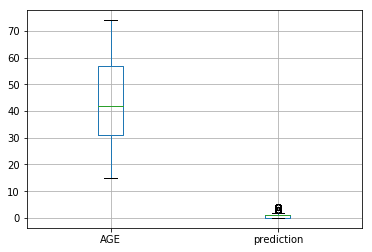

In [120]:
%matplotlib inline

pandas_df.boxplot()

### 5.2 Accessing data mart metrics
- performance
- quality
- fairness

Get all metrics.

In [121]:
client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': '8d3fdf56-57fd-4a37-b614-01caada3507f',
    'asset_type': 'model',
    'created_at': '2018-11-02T11:13:53.971Z',
    'name': 'drug-selection',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/published_models/8d3fdf56-57fd-4a37-b614-01caada3507f'},
   'deployment': {'created_at': '2018-11-02T13:01:57.449Z',
    'deployment_id': 'c6910b7e-2440-41d0-81f1-a098ec041273',
    'deployment_type': 'online',
    'name': 'best-drug model deployment',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/c6910b7e-2440-41d0-81f1-a098ec041273'},
   'metrics': [{'issues': 3,
     'metric_type': 'fairness',
     'timestamp': '2018-11-02T13:07:50.608659Z',
     'value': {'manual_labelling_store': 'FM_Manual_Labeling_8d3fdf56_57fd_4a37_b614_01caada3507f',
      'metrics': [{'bias_source': {'values': [{'fav_percent': 50.0,
           'range': '[57,58

Get metric for particular deployment.

In [122]:
subscription.quality_monitoring.get_metrics(deployment_uid=subscription.get_deployment_uids()[0])

{'end': '2018-11-02T13:09:17.583510Z',
 'metrics': [{'asset_revision': 'ce7a5136-662a-430a-bd15-8d9d65091771',
   'process': 'learning iteration [5412431f-d259-4166-9c84-193583172b35]',
   'timestamp': '2018-11-02T13:08:04.947Z',
   'value': {'metrics': [{'name': 'weightedTruePositiveRate', 'value': 0.25},
     {'name': 'accuracy', 'threshold': 0.8, 'value': 0.25},
     {'name': 'weightedFMeasure', 'value': 0.4000000000000001},
     {'name': 'weightedRecall', 'value': 0.25},
     {'name': 'weightedPrecision', 'value': 1.0}],
    'phase': 'monitoring',
    'quality': 0.25,
    'threshold': 0.8}}],
 'start': '2018-11-02T12:06:37.473Z'}

<a id="setup"></a>
## 6. Visualization

Get the performance metrics as pandas dataframe.

In [138]:
performance_pdf = subscription.performance_monitoring.get_table_content()

Let's enrich our data by calculating additional metric: `throughput`

In [139]:
performance_pdf['throughput'] = performance_pdf.apply(lambda row: float((row.records/row.response_time*1000)) ,axis=1)
performance_pdf['date'] = performance_pdf['ts'].dt.date
performance_aggregated_daily = performance_pdf.groupby(['date']).agg({'throughput': 'mean', 'records': sum, 'response_time': sum})

Let's plot metrics over time.

In [140]:
import sys
import os
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]]))

Create traces.

In [141]:
trace1 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['throughput'],
    orientation = 'h',
    name='throughput'
)

trace2 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['records'],
    orientation = 'h',
    name='records'
)

trace3 = go.Bar(
    y=performance_aggregated_daily.index,
    x=performance_aggregated_daily['response_time'],
    orientation = 'h',
    name='response time'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Performance metrics daily',
    barmode='group',
    xaxis=dict(title='Metric value'),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.